In [2]:
from model import ImageAudioSiameseNetwork
from loss import TripletLoss
from dataset import ImageAudioDataset
from data_prep import prepare_zsl_split_img_audio
from transforms import get_transforms
from model_manager import ModelManager
from utils import *

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_network = ImageAudioSiameseNetwork().to(device)
triplet_loss = TripletLoss(0.5).to(device)
img_transforms, mel_transform = get_transforms()

In [11]:
optimizer_siamese = optim.Adam(siamese_network.parameters(), lr=0.01)
exp_lr_scheduler = ReduceLROnPlateau(
    optimizer_siamese, 
    mode='min', 
    factor=0.2, 
    patience=5, 
    verbose=True
)

In [12]:
curr_model = ModelManager(
    siamese_network, 
    triplet_loss, 
    optimizer_siamese, 
    exp_lr_scheduler, 
    device
)

In [13]:
curr_model.load_model('./checkpoints/img_audio_221128/w_ep-00195_l-0.0908.pth')

Loading model done: ./checkpoints/img_audio_221128/w_ep-00195_l-0.0908.pth


In [15]:
(
    seen_img_classes,
    seen_img_path,
    seen_img_label,
    seen_audio_X_train, 
    seen_audio_y_train, 
    seen_audio_X_test, 
    seen_audio_y_test,
    unseen_img_classes,
    unseen_img_path,
    unseen_img_label,
    unseen_audio_X_train, 
    unseen_audio_y_train, 
    unseen_audio_X_test, 
    unseen_audio_y_test,
) = prepare_zsl_split_img_audio()

In [30]:
seen_img_audio_dataset_tr = ImageAudioDataset(
    audio_path_list = seen_audio_X_train,
    audio_label_list = seen_audio_y_train,
    img_path_list = seen_img_path,
    img_label_list = seen_img_label,
    img_class_list = seen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)
seen_img_audio_dataset_ts = ImageAudioDataset(
    audio_path_list = seen_audio_X_test,
    audio_label_list = seen_audio_y_test,
    img_path_list = seen_img_path,
    img_label_list = seen_img_label,
    img_class_list = seen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)

In [31]:
seen_img_audio_dataloaders = {}
seen_img_audio_dataloaders['train'] = DataLoader(
    seen_img_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
seen_img_audio_dataloaders['test'] = DataLoader(
    seen_img_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

## 1. Seen class prediction

In [32]:
(
    seen_tr_audio_embs, 
    seen_random_img_embs, 
    seen_tr_labels, 
    seen_tr_loss
) = curr_model.infer_all(seen_img_audio_dataloaders, 'train')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.62it/s]

train Loss: 0.0786


In [33]:
(
    seen_ts_audio_embs, 
    seen_random_img_embs, 
    seen_ts_labels, 
    seen_ts_loss
) = curr_model.infer_all(seen_img_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:11<00:00, 10.60it/s]

test Loss: 0.0485


### 1-1. Computing all image embeddings (seen classes)

In [69]:
from PIL import Image
from collections import defaultdict
import torch.nn as nn

seen_all_img_embs = []
for i in tqdm(range(len(seen_img_path))):
    _img = img_transforms['test'](Image.open(seen_img_path[i])).unsqueeze(0).to(device)
    _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
    _img = torch.squeeze(_img, dim=-1)
    _img = torch.squeeze(_img, dim=-1)
    _img = curr_model.model.visual_projection(_img)
    seen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 47.47it/s]


In [70]:
seen_class_to_img_embs = defaultdict(list)   
for i in tqdm(range(len(seen_all_img_embs))):
    seen_class_to_img_embs[seen_img_label[i]].append(seen_all_img_embs[i])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1271964.82it/s]


### 1-2. Use training set audio embeddings (seen classes)

In [71]:
seen_class_to_audio_embs = defaultdict(list)
for i in tqdm(range(seen_tr_audio_embs.shape[0])):
    seen_class_to_audio_embs[seen_tr_labels[i]].append(seen_tr_audio_embs[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 495195.28it/s]


In [72]:
for i in range(len(list(seen_class_to_audio_embs.keys()))):
    print(seen_img_classes[i], len(seen_class_to_audio_embs[i]), len(seen_class_to_img_embs[i]))  

bassoon 100 200
flute 96 200
trumpet 76 200
violin 228 200


### 1-3. Compute the mean vector for each class

In [73]:
seen_class_to_mean_audio_emb, seen_class_to_mean_img_emb = {}, {}
for _c in seen_class_to_audio_embs:
    seen_class_to_mean_audio_emb[_c] = np.mean(seen_class_to_audio_embs[_c], axis=0)
    seen_class_to_mean_img_emb[_c] = np.mean(seen_class_to_img_embs[_c], axis=0)

### 1-4. Test set audio to seen class (mean image embedding) prediction (supervised learning evaluation)

In [74]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_mean_img_emb, 
                                                  seen_img_classes,
                                                  1)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / seen_ts_audio_embs.shape[0])

Top-1 acc : 0.8145161290322581


### 1-5. Seen class (mean image embedding) to test set audio retrieval (supervised learning evaluation)

In [81]:
# TODO

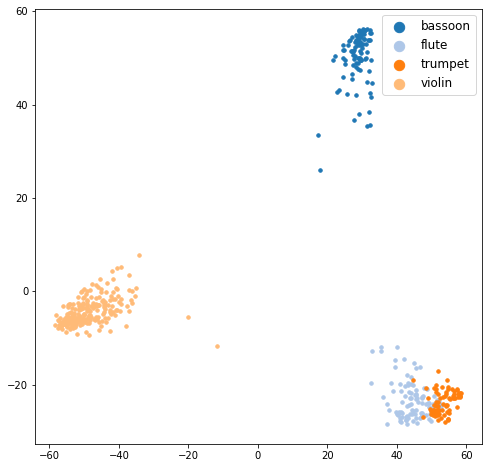

In [76]:
draw_pca(seen_tr_audio_embs, seen_tr_labels, seen_img_classes)

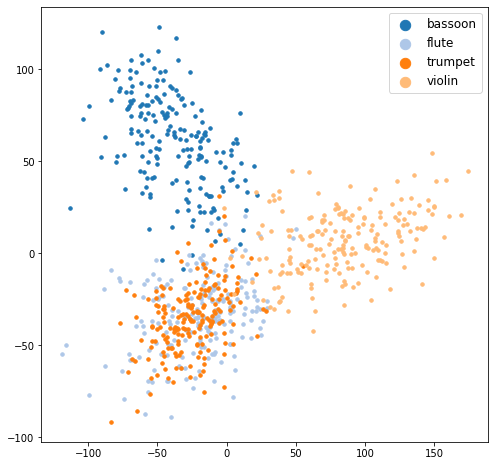

In [83]:
draw_pca(seen_all_img_embs, seen_img_label, seen_img_classes)

## 2. Unseen class prediction

In [41]:
unseen_img_audio_dataset_tr = ImageAudioDataset(
    audio_path_list = unseen_audio_X_train,
    audio_label_list = unseen_audio_y_train,
    img_path_list = unseen_img_path,
    img_label_list = unseen_img_label,
    img_class_list = unseen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)
unseen_img_audio_dataset_ts = ImageAudioDataset(
    audio_path_list = unseen_audio_X_test,
    audio_label_list = unseen_audio_y_test,
    img_path_list = unseen_img_path,
    img_label_list = unseen_img_label,
    img_class_list = unseen_img_classes,
    audio_transform = mel_transform,
    img_transform = img_transforms['test']
)

In [43]:
unseen_img_audio_dataloaders = {}
unseen_img_audio_dataloaders['train'] = DataLoader(
    unseen_img_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
unseen_img_audio_dataloaders['test'] = DataLoader(
    unseen_img_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

In [44]:
(
    unseen_tr_audio_embs, 
    unseen_random_img_embs, 
    unseen_tr_labels, 
    unseen_tr_loss
) = curr_model.infer_all(unseen_img_audio_dataloaders, 'train')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 520/520 [00:48<00:00, 10.70it/s]

train Loss: 0.3953


In [45]:
(
    unseen_ts_audio_embs, 
    unseen_random_img_embs, 
    unseen_ts_labels, 
    unseen_ts_loss
) = curr_model.infer_all(unseen_img_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:12<00:00, 10.82it/s]

test Loss: 0.3146


### 2-1. Computing all image embeddings (unseen classes)

In [84]:
unseen_all_img_embs = []
for i in tqdm(range(len(unseen_img_path))):
    _img = img_transforms['test'](Image.open(unseen_img_path[i])).unsqueeze(0).to(device)
    _img = nn.Sigmoid()(curr_model.model.visual_model(_img))
    _img = torch.squeeze(_img, dim=-1)
    _img = torch.squeeze(_img, dim=-1)
    _img = curr_model.model.visual_projection(_img)
    unseen_all_img_embs.append(_img.squeeze().detach().cpu().numpy())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.37it/s]


In [85]:
unseen_class_to_img_embs = defaultdict(list)   
for i in tqdm(range(len(unseen_all_img_embs))):
    unseen_class_to_img_embs[unseen_img_label[i]].append(unseen_all_img_embs[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 594409.78it/s]


### 2-2. Use training set audio embeddings (unseen classes)

In [86]:
unseen_class_to_audio_embs = defaultdict(list)
for i in tqdm(range(unseen_tr_audio_embs.shape[0])):
    unseen_class_to_audio_embs[unseen_tr_labels[i]].append(unseen_tr_audio_embs[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 515246.42it/s]


### 2-3. Compute the mean vector for each class

In [87]:
unseen_class_to_mean_audio_emb, unseen_class_to_mean_img_emb = {}, {}
for _c in unseen_class_to_audio_embs:
    unseen_class_to_mean_audio_emb[_c] = np.mean(unseen_class_to_audio_embs[_c], axis=0)
    unseen_class_to_mean_img_emb[_c] = np.mean(unseen_class_to_img_embs[_c], axis=0)

### 2-4. Test set audio of unseen class (mean image embedding) prediction (zero-shot evaluation)

In [88]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                                  unseen_class_to_mean_img_emb, 
                                                  unseen_img_classes,
                                                  1)
    if unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-1 acc : 0.5461538461538461


### 2-5. Unseen class (mean image embedding) to test set audio retrieval (zero-shot evaluation)

In [89]:
# TODO

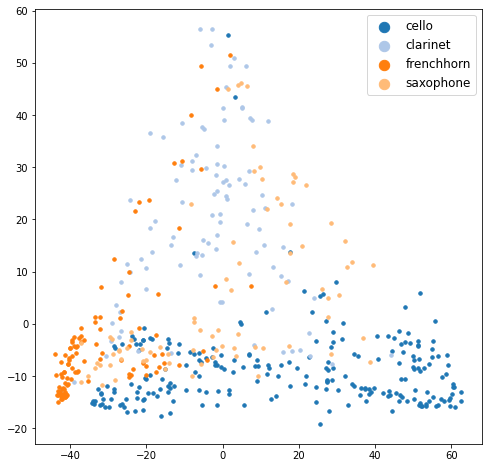

In [91]:
draw_pca(unseen_tr_audio_embs, unseen_tr_labels, unseen_img_classes)

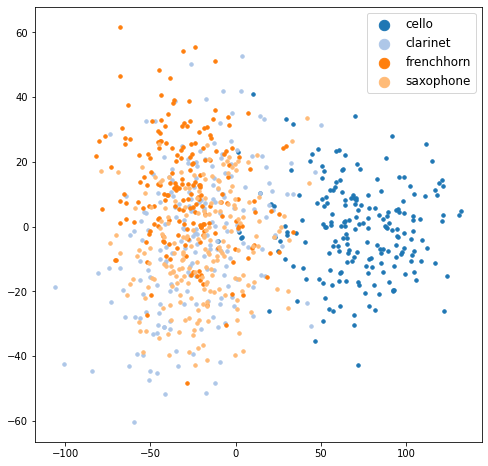

In [92]:
draw_pca(unseen_all_img_embs, unseen_img_label, unseen_img_classes)

## Generalized ZSL evaluation

In [93]:
all_img_classes = seen_img_classes + unseen_img_classes

In [106]:
all_img_classes

['bassoon',
 'flute',
 'trumpet',
 'violin',
 'cello',
 'clarinet',
 'frenchhorn',
 'saxophone']

In [111]:
added_unseen_tr_labels = [_n + 4 for _n in unseen_tr_labels]
added_unseen_ts_labels = [_n + 4 for _n in unseen_ts_labels]
added_unseen_img_label = [_n + 4 for _n in unseen_img_label]

In [112]:
all_tr_audio_embs = np.concatenate([seen_tr_audio_embs, unseen_tr_audio_embs])
all_img_embs = np.concatenate([seen_all_img_embs, unseen_all_img_embs])
all_img_label = seen_img_label + added_unseen_img_label

In [113]:
all_tr_labels = seen_tr_labels + added_unseen_tr_labels
all_ts_labels = seen_ts_labels + added_unseen_ts_labels

In [114]:
all_class_to_mean_img_emb = {}
for _c, _emb in seen_class_to_mean_img_emb.items():
    all_class_to_mean_img_emb[_c] = _emb
for _c, _emb in unseen_class_to_mean_img_emb.items():
    all_class_to_mean_img_emb[_c+4] = _emb

In [116]:
correct = 0
for idx in range(unseen_tr_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_tr_audio_embs[idx], 0), 
                                            all_class_to_mean_img_emb, 
                                            all_img_classes,
                                            1)
    if added_unseen_tr_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_tr_audio_embs.shape[0])

Top-3 acc : 0.09230769230769231


In [117]:
correct = 0
for idx in range(unseen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_ts_audio_embs[idx], 0), 
                                            all_class_to_mean_img_emb, 
                                            all_img_classes,
                                            1)
    if added_unseen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-3 acc :', correct / unseen_ts_audio_embs.shape[0])

Top-3 acc : 0.14615384615384616


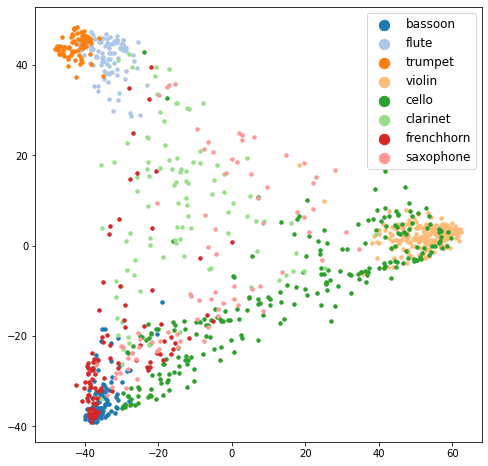

In [119]:
draw_pca(all_tr_audio_embs, all_tr_labels, all_img_classes)

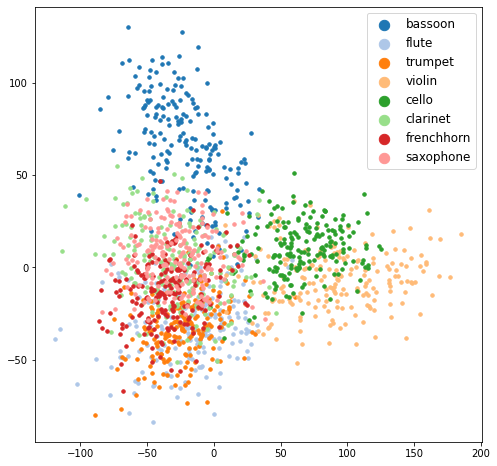

In [120]:
draw_pca(all_img_embs, all_img_label, all_img_classes)